In [11]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import janitor as jn

# Modeling libraries
from sklearn.model_selection import train_test_split
# Time series libraries
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Model packing
import joblib 

In [12]:
DATA_PATH = '../data/raw/dataset_demand_acumulate.csv'
df_raw = pd.read_csv(DATA_PATH)
df_raw = jn.clean_names(df_raw)
df = df_raw.copy()
print("=="*50)
print(df_raw.shape)
print("=="*50)
print(df_raw.dtypes)
print("=="*50)
print(df.head(3))
print("=="*50)
# Numer of NA Values
print("Total NA vals\n",df.isna().sum())
print("=="*50)
# Check for duplicates
print("Total Duplicated vals\n",df.duplicated().sum())
print("=="*50)
# Summary statistics
print(df.describe(include='all'))

(64, 2)
year_month     object
demand        float64
dtype: object
  year_month       demand
0    2017-01  1211.009490
1    2017-02  1660.584649
2    2017-03  3182.587014
Total NA vals
 year_month    0
demand        0
dtype: int64
Total Duplicated vals
 0
       year_month       demand
count          64    64.000000
unique         64          NaN
top       2017-01          NaN
freq            1          NaN
mean          NaN  2600.044986
std           NaN  1943.995938
min           NaN   217.314949
25%           NaN  1034.370651
50%           NaN  1947.817229
75%           NaN  4216.465081
max           NaN  7686.307292


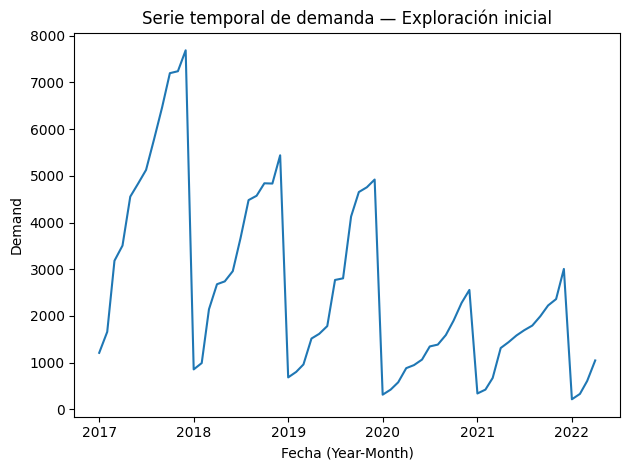

In [13]:
# Cambio de estructura - Arreglando fecha
df["year_month"] = pd.to_datetime(df["year_month"], format="%Y-%m", errors="coerce")
plt.figure()
plt.plot(df["year_month"], df["demand"] if "demand" in df.columns else np.nan)
plt.title("Serie temporal de demanda — Exploración inicial")
plt.xlabel("Fecha (Year-Month)")
plt.ylabel("Demand")
plt.tight_layout()
plt.show()

**Insigths** Hasta  el momento se han encontrado los siguietnes hallazgos:
 * Data limpia: No se ven datos nulos, faltantes o mal inputados. 
 * Sobre la serie de tiempo: La data es desde 2017 hasta el 2022, con una frecuencia mensual (64 datos), se ve un comportamiendo ciclico (Estacional) y en un principio, no estacionario (indica que se han de tomar medias para pronosticar), Picos marcados a final de año indicando tendencia alcista por año. Se proponen mas graficos para entender mejor el proceso. 

C:\Users\JhonatanSmithGarcía\AppData\Local\Temp\ipykernel_44120\1498088547.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(data_by_month, labels=[str(m) for m in range(1, 13)], showmeans=True)


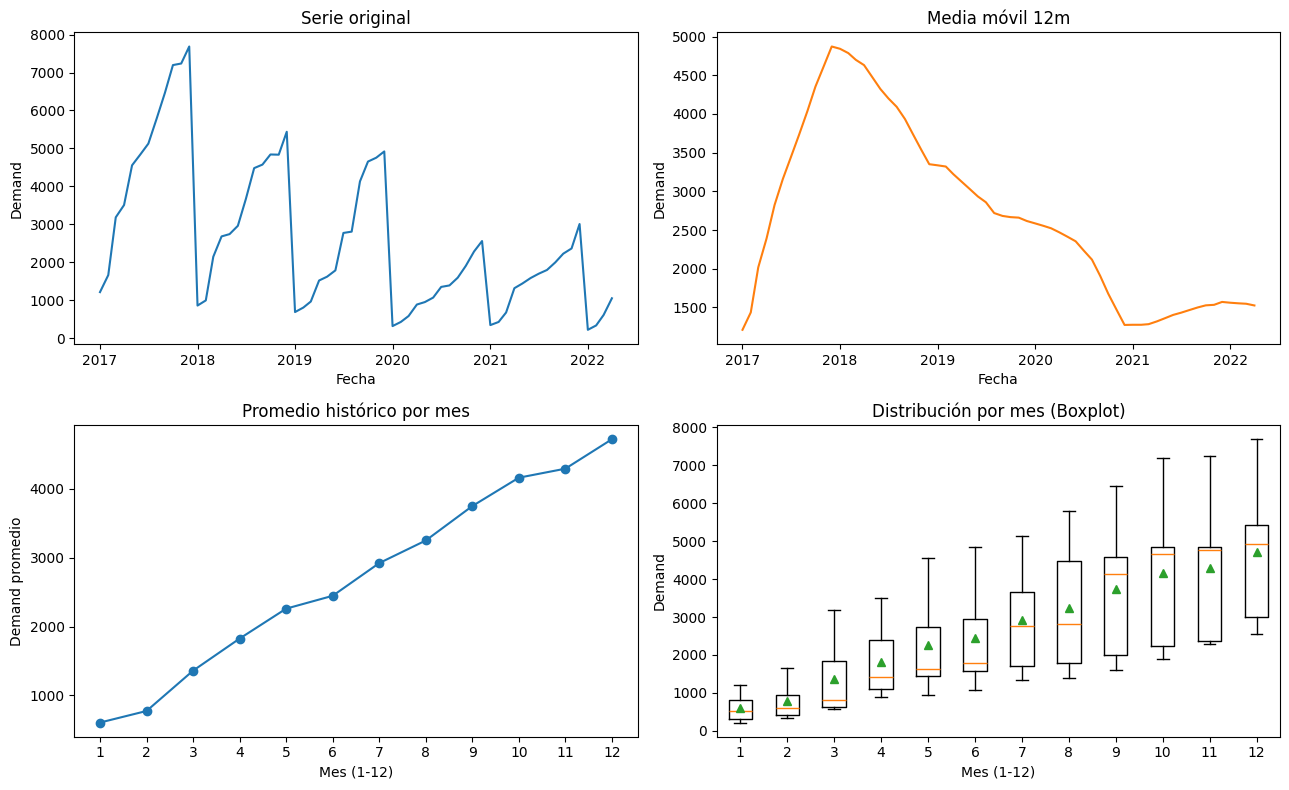

In [14]:

# Data temporal
df = df.copy()
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m', errors='coerce')
ts = df.set_index('year_month').asfreq('MS')["demand"]

# datos agregados
roll12 = ts.rolling(12, min_periods=1).mean()
monthly_mean = ts.groupby(ts.index.month).mean()
data_by_month = [ts[ts.index.month == m].dropna().values for m in range(1, 13)]

# on gridd + subplots
fig, axs = plt.subplots(2, 2, figsize=(13, 8))
(ax1, ax2), (ax3, ax4) = axs

# (1) Serie original
ax1.plot(ts.index, ts.values, color='tab:blue')
ax1.set_title("Serie original")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Demand")

# (2) Media móvil 12m
ax2.plot(ts.index, roll12.values, color='tab:orange')
ax2.set_title("Media móvil 12m")
ax2.set_xlabel("Fecha")
ax2.set_ylabel("Demand")

# (3) Promedio histórico por mes
ax3.plot(monthly_mean.index, monthly_mean.values, marker="o")
ax3.set_title("Promedio histórico por mes")
ax3.set_xlabel("Mes (1-12)")
ax3.set_ylabel("Demand promedio")
ax3.set_xticks(range(1, 13))

# (4) Boxplot por mes
ax4.boxplot(data_by_month, labels=[str(m) for m in range(1, 13)], showmeans=True)
ax4.set_title("Distribución por mes (Boxplot)")
ax4.set_xlabel("Mes (1-12)")
ax4.set_ylabel("Demand")

plt.tight_layout()
plt.show()


**Insigiths**
 * Tendencia alcista: Existe una clara tendencia enq ue el promedio aumenta con el tiempo (grafico 3). Esto indica tendencia en el proceso.
 * Los BoxPlot muestran una tendencia mensual donde el promedio demandado aumenra considerablemente en el ultimo trimestre del año. 
 * La media movil caputara una tendencia global bajista en los datos (spike alto y caida lenta) producto probablemente de comportamiento estacional anivel granular. Esto indica un seanonal component (Apuintando a un SARIMAX) para ser tenido en cuenta. Esto significa que como minimo, se espera una autocorrelacion parcial de Lag 12 (los eneros se parecen entre si, los febreros entre si, etc), Ergo m=12 en un modelo SARIMA

# Pruebas de ACF y PAC

La ACF (Autocorrelation Function) mire la correlacion lineal de una serie de tiempo consigo misma en el tiempo vs sus lags (rezagos: Separacion equidistancte entre 2 puntos) e indica la relacion entre valores pasados con el presente. Sirve para encontrar aptrones estacionales y el orden de terminos MA (Media mobil) de un modelo ARMA (Autoregresivo de media movil, con esto, se calcula el comon´ponente MA)

Por su aprte, la PACF (Partual autocorrelation Function) mide la autocorrelacion parciañl de la seroe, mide ecencialmente lo mismo que la anterior eliminando el efecto intermedio de los rezagos "mas lejanos", clave para determinar el componente AR.

ACF y PACF son fundamentales para entender la estructura de dependencia en series temporales y para seleccionar parámetros en modelos ARIMA/ARMA de manera eficiente. La idea detras de todo esto es empezar con un modelo sencillito, nada muy fancy, para empezar a correr pruebas locales para luego desplegar el servicio on premise. 

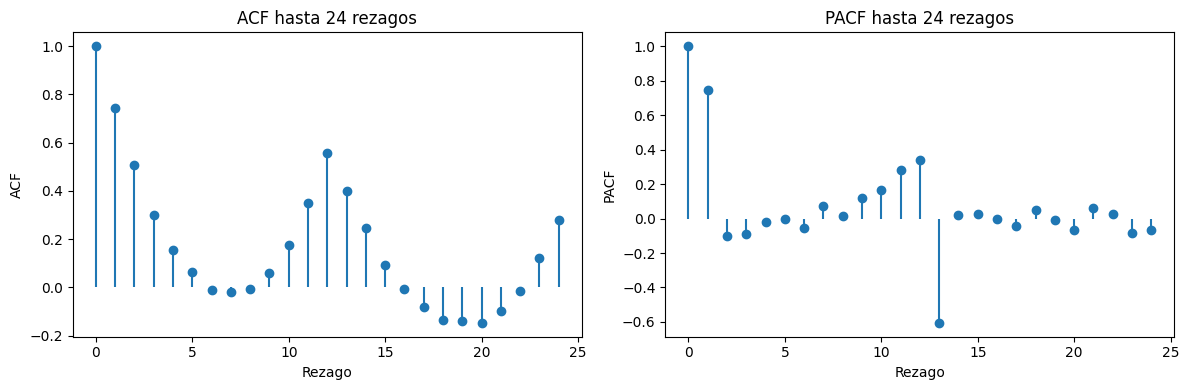

In [15]:

# --- Cálculos ---
nlags = 24
acf_vals = acf(ts.dropna(), nlags=nlags, fft=True)
pacf_vals = pacf(ts.dropna(), nlags=nlags, method="ywm")

# --- Figura lado a lado ---
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# ACF
axs[0].stem(range(len(acf_vals)), acf_vals, basefmt=" ")
axs[0].set_title("ACF hasta 24 rezagos")
axs[0].set_xlabel("Rezago")
axs[0].set_ylabel("ACF")

# PACF
axs[1].stem(range(len(pacf_vals)), pacf_vals, basefmt=" ")
axs[1].set_title("PACF hasta 24 rezagos")
axs[1].set_xlabel("Rezago")
axs[1].set_ylabel("PACF")

plt.tight_layout()
plt.show()


**Insigths**
 * ACF Cae lentamente: Tiene picos significativos en2,3,y1,con un comportamiento senoidal. Posible autocorrelacion y componente estacional anual (rezago 12), evidenciado de manera descriptvoa. El decaimiento lento implica modeloado Autoregresivo(AR)
 * PACF: Corte fuerte en 1 y 2 y muyu marcado en 12, indica un orden AR en 1 o 2 conm un rezafgo fuerte en 12. 

La conclusion final es un p(AR): {1,2} y un q(MA): {1,2}; Para tener un modelo ARMA, pero ojo, esto presupone un proceso estacionario en media y falta verificar proceso estacional. Las isguietnes pruebas ayudan a dictaminar esto

In [ ]:
# --- Prueba ADF (estacionariedad) --------------------------------------------------------------
adf_stat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(ts.dropna(), autolag="AIC")
print("Prueba ADF — Serie original")
print(f"- p-value: {pvalue:.6f}")
print(f"- Lags usados: {usedlag}")
print("\nGuía: p-value < 0.05 → estacionaria (en el sentido de ADF). ADF no 'quita' estacionalidad;")
print("      si hay patrón anual fuerte, SARIMA/Prophet siguen siendo candidatos naturales.")

Prueba ADF — Serie original
- Estadístico ADF: -4.4410
- p-value: 0.000251
- Lags usados: 11
- N obs: 52
- Valores críticos: {'1%': np.float64(-3.562878534649522), '5%': np.float64(-2.918973284023669), '10%': np.float64(-2.597393446745562)}
- AIC del modelo ADF: 831.3424

Guía: p-value < 0.05 → estacionaria (en el sentido de ADF). ADF no 'quita' estacionalidad;
      si hay patrón anual fuerte, SARIMA/Prophet siguen siendo candidatos naturales.


**Insithg**

 * Con eto se concluye quye la serie ya es estacionaria en media (Tendencia)
 * Se recomeinjda usar un comportamiento SARIMA

# Modelling

Se propone crear un analisis de modelado para la prediccion. Se propone entrenar con toda la data menos los utlimos 4 meses. Ahora, ya tenemos unas nocioens de cual seria el mejor modelo a usar sin embargo, existe la posibilidad de hacer un gridsearch con la funcion de autoarima para que esta ejecute de manera inmediata una corrida con todos los posibles modelos dado c iertos hiperparametros y sleeccione el mejor basado en alguna metrica.

In [17]:

VAL_MONTHS = 4 # Meses a usar como testing, cojo los ultimos 4 meses y los quito de la data, entreno modelo con el resto 
last_obs = ts.index.max() # Ultima fecha 
valid_start = last_obs - pd.DateOffset(months=VAL_MONTHS-1) # Primer mes de validacion 
train_end = valid_start - pd.DateOffset(months=1) # Ultimo mes de entrenamiento 
# Train test split: Y 
y_tr = ts.loc[:train_end] 
y_va = ts.loc[valid_start:] 
print("Train hasta:", train_end.date(), " | Valid desde:", valid_start.date(), "→", ts.index.max().date()) 

Train hasta: 2021-12-01  | Valid desde: 2022-01-01 → 2022-04-01


c:\Users\JhonatanSmithGarcía\OneDrive - Celerik\Desktop\Repositorios\Personales\PT-Summa\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\JhonatanSmithGarcía\OneDrive - Celerik\Desktop\Repositorios\Personales\PT-Summa\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\JhonatanSmithGarcía\OneDrive - Celerik\Desktop\Repositorios\Personales\PT-Summa\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\JhonatanSmithGarcía\OneDrive - Celerik\Desktop\Repositorios\Personales\PT-Summa\venv\lib\site-packages\statsm

Mejor: order=(2, 0, 2), seas=(1, 1, 0, 12) | RMSE=76.62  MAE=66.99  MAPE=16.84%


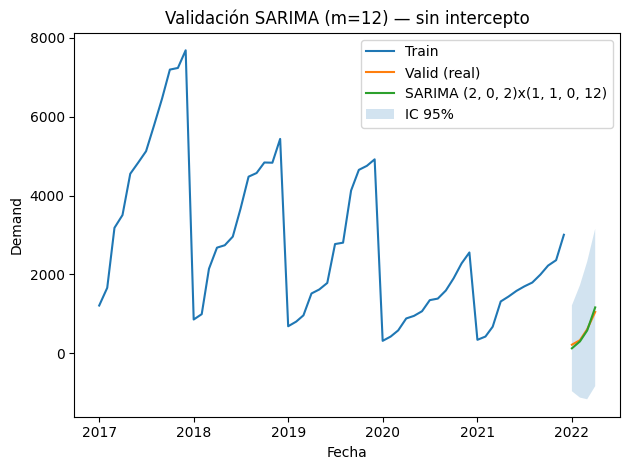

In [ ]:
# Busqeuda de modelo mas optimo 
def rmse(a,b): return float(np.sqrt(np.mean((np.array(a)-np.array(b))**2)))
def mae(a,b):  return float(np.mean(np.abs(np.array(a)-np.array(b))))
def mape(a,b):
    a = np.array(a); b = np.array(b); eps = 1e-8
    return float(np.mean(np.abs((a-b)/np.where(a==0, eps, a))) * 100)

orders  = [(1,0,1),(1,0,2),(2,0,1),(2,0,2)]
sorders = [(1,1,0,12),(1,1,1,12),(0,1,1,12)]

best = None
for o in orders:
    for so in sorders:
        try:
            fit  = SARIMAX(y_tr, order=o, seasonal_order=so, trend='n',
                           enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            pred = fit.predict(start=y_va.index[0], end=y_va.index[-1])
            score = rmse(y_va, pred)
            if (best is None) or (score < best["RMSE"]):
                best = {"o": o, "so": so, "fit": fit, "pred": pred,
                        "RMSE": score, "MAE": mae(y_va,pred), "MAPE": mape(y_va,pred)}
        except Exception:
            pass

print(f"Mejor: order={best['o']}, seas={best['so']} | RMSE={best['RMSE']:.2f}  MAE={best['MAE']:.2f}  MAPE={best['MAPE']:.2f}%")

# Gráfico validación + IC 95%
pr = best["fit"].get_prediction(start=y_va.index[0], end=y_va.index[-1])
ci = pr.conf_int(0.05)
plt.figure()
plt.plot(y_tr.index, y_tr.values, label="Train")
plt.plot(y_va.index, y_va.values, label="Valid (real)")
plt.plot(pr.predicted_mean.index, pr.predicted_mean.values, label=f"SARIMA {best['o']}x{best['so']}")
plt.fill_between(pr.predicted_mean.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, label="IC 95%")
plt.title("Validacion SARIMA (m=12)")
plt.xlabel("Fecha"); plt.ylabel("Demand"); plt.legend(); plt.tight_layout(); plt.show()


En general, el modelo presenta un buen rendimiento. Los parametros seleccionados s ehicero a "ojo" pero ojko, siempore esta la opcion de hacer un gridsearch.

Con esot ya se entiende cual seria el flujo general final y se propone crear un .py que se encargar´de todo este proceso de entrenamiento del modelo.